# 📚 Instalasi dan Import Library
Pada tahap awal ini, kita melakukan instalasi dan impor berbagai library yang dibutuhkan untuk preprocessing, analisis, dan pemodelan teks, khususnya untuk teks berbahasa Indonesia. Library seperti Sastrawi digunakan untuk stemming kata dalam Bahasa Indonesia, gensim untuk membuat representasi vektor kata (Word2Vec), dan versi khusus dari numpy serta scipy digunakan untuk menjaga kompatibilitas antar library. Library standar seperti pandas, numpy, dan matplotlib digunakan untuk manipulasi data dan visualisasi. TensorFlow digunakan sebagai framework deep learning, sementara scikit-learn berperan dalam preprocessing dan evaluasi model. Untuk pemrosesan teks, digunakan juga nltk, serta tools dari Keras untuk tokenisasi dan padding.

In [1]:
# Instalasi library
!pip install Sastrawi
!pip install gensim==4.3.1
!pip install numpy==1.25.2
!pip install scipy==1.10.1

  Using cached scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
Using cached scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.1 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires scipy>=1.11.1, but you have scipy 1.10.1 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, but you have scipy 1.10.1 which is incompatible.
scikit-image 0.25.2 requires scipy>=1.11.4, but you have scipy 1.10.1 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.10.1 which is incompatible.
xarray-einstats 0.9.0 requires scipy>=1.11, but you have scipy 1.10.1 which is incompatible.
cvxpy 

In [2]:
# Import library standar untuk analisis data dan deep learning
import os
import re
import string
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Import tools dari scikit-learn untuk pembagian data dan evaluasi model
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Import library NLP tambahan untuk pemrosesan teks
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud
from gensim.models import Word2Vec

In [3]:
# Download resource penting dari NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# 📥 Data Loading dan Eksplorasi Awal
Tahapan awal ini berfokus pada pemuatan dan eksplorasi awal data. Di sinilah kita memastikan bahwa data bersih, tidak duplikat, dan dalam format yang sesuai untuk dianalisis. Tahapan ini sangat penting karena kualitas data akan berdampak langsung pada kualitas hasil analisis dan model yang dibangun.

## 🔹 Data Loading
Langkah pertama adalah memuat dataset dari sumber eksternal, dalam hal ini Google Drive. File dibaca ke dalam DataFrame `pandas` untuk dianalisis dan diproses lebih lanjut. Selain itu, ditampilkan beberapa baris awal serta informasi tipe data untuk memahami struktur dataset.

In [4]:
# Load data dari Google Drive
file_id = '16z9zidu0XDkK3tB_1HGPUPc9al_nGXpb'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url, on_bad_lines='skip')

In [5]:
# Tampilkan lima baris pertama data
df.head()

,deskripsi,kategori
0,Nasi uduk betawi komplit dengan semur jengkol ...,Food & Beverage
1,Makan siang pecel lele dan tempe goreng 28.000,Food & Beverage
2,Nongkrong di kafe dengan latte art 45.000,Food & Beverage
3,Beli terang bulan red velvet keju 60.000,Food & Beverage
4,Makan malam steak wagyu A5 250.000,Food & Beverage


In [6]:
# Tampilkan struktur dan tipe data pada dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7103 entries, 0 to 7102
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   deskripsi  7103 non-null   object
 1   kategori   7103 non-null   object
dtypes: object(2)
memory usage: 111.1+ KB


📌 **Insight:** Dataset memuat 7.103 baris dan 2 kolom, yakni `deskripsi` dan `kategori`. Kedua kolom bertipe data `object`, yang biasanya merepresentasikan teks atau data kategorikal dalam pandas.

## 🔹 Pengecekan Missing Value
Penting untuk mengetahui apakah terdapat nilai kosong atau hilang pada dataset. Hal ini dapat memengaruhi proses analisis dan training model jika tidak ditangani dengan tepat.

In [7]:
# Cek apakah ada nilai kosong (missing value)
df.isna().sum()

,0
deskripsi,0
kategori,0


## 🔹 Deteksi dan Penghapusan Duplikat
Duplikasi data dapat menyebabkan bias pada model karena satu informasi dianggap lebih penting dari yang lain. Oleh karena itu, data duplikat perlu diidentifikasi dan dihapus.

In [8]:
# Cek apakah ada data duplikat
df.duplicated().sum()

57

In [9]:
# Hapus data duplikat
clean_df = df.drop_duplicates()
clean_df.duplicated().sum()

0

📌 **Insight:** Ditemukan 57 data duplikat dalam dataset, yang kemudian dihapus untuk meningkatkan kualitas data. Penghapusan ini penting guna mencegah bias atau overfitting selama proses pelatihan model, serta memastikan bahwa setiap sampel mewakili informasi unik.

## 🔹 Ekstraksi Informasi Angka dari Teks
Dalam beberapa kasus, informasi numerik (seperti jumlah uang) tersimpan dalam teks deskripsi. Fungsi ini digunakan untuk mengekstrak angka terakhir yang muncul dari setiap entri teks.

In [10]:
# Fungsi untuk mengekstrak angka dari deskripsi teks
def extract_amount(teks):
    matches = re.findall(r'\d{1,3}(?:\.\d{3})*|\d+', str(teks))
    if matches:
        last_amount = matches[-1].replace('.', '').strip()
        if last_amount:
            return int(last_amount)
    return None

## 🔹 Preprocessing Teks Mentah
Tahapan ini penting untuk membersihkan teks dari noise dan menyederhanakan struktur teks agar dapat diproses model. Termasuk di dalamnya: pembersihan karakter khusus, transformasi huruf, penghapusan kata tidak penting (stopwords), dan normalisasi kata (stemming & slang fixing).

In [11]:
# Fungsi membersihkan teks dari karakter tidak penting
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

# Fungsi mengubah huruf menjadi huruf kecil semua
def casefoldingText(text):
    text = text.lower()
    return text

# Fungsi tokenisasi teks menjadi list kata
def tokenizingText(text):
    text = word_tokenize(text)
    return text

# Fungsi menghapus stopwords dari bahasa Indonesia dan Inggris
def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy", "beli", "rp"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

# Fungsi stemming menggunakan Sastrawi
def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

# Fungsi mengubah list kata menjadi kalimat
def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [12]:
# Daftar kata slang yang digunakan dalam percakapan sehari-hari
slangwords = {"7an":"tujuan", "@":"di", "ababil":"abg labil", "abis":"habis", "acc":"accord", "ad":"ada", "adlah":"adalah", "adlh":"adalah", "adoh":"aduh", "afaik":"as far as i know", "aha":"tertawa", "ahaha":"haha", "aing":"saya", "aj":"saja", "aja":"saja", "ajep-ajep":"dunia gemerlap", "ajj":"saja", "ak":"saya", "aka":"dikenal juga sebagai", "akika":"aku", "akko":"aku", "akkoh":"aku", "akku":"aku", "akuwh":"aku", "akyu":"aku", "alay":"norak", "aljasa":"asal jadi saja", "alow":"halo", "ama":"sama", "ambilin":"ambilkan", "ambl":"ambil", "ancur":"hancur", "anjir":"anjing", "anjrit":"anjing", "ank":"anak", "anter":"antar", "ap":"apa", "ap2":"apa-apa", "apaan":"apa", "apasih":"apa sih", "ape":"apa", "apes":"sial", "aplot":"unggah", "aps":"apa", "apva":"apa", "aq":"saya", "aqu":"aku", "aquwh":"aku", "asap":"sesegera mungkin", "asbun":"asal bunyi", "aseek":"asyik", "aseekk":"asyik", "asek":"asyik", "asekk":"asyik", "aseknya":"asyiknya", "asem":"asam", "asoy":"asyik", "aspal":"asli tetapi palsu", "astrojim":"astagfirullahaladzim", "astul":"asal tulis", "ath":"kalau begitu", "ato":"atau", "atuh":"kalau begitu", "au ah":"tidak mau tahu", "ava":"avatar", "awak":"saya", "aws":"awas", "ay":"sayang", "ayang":"sayang", "ayank":"sayang", "ayok":"ayo", "b4":"sebelum", "bacot":"banyak bicara", "bakalan":"akan", "bales":"balas", "bandes":"bantuan desa", "bangdes":"pembangunan desa", "bangedh":"banget", "bangkotan":"tua", "banpol":"bantuan polisi", "banpres":"bantuan presiden", "banpur":"bantuan tempur", "bansarkas":"bantuan sarana kesehatan", "basbang":"basi", "bazis":"badan amal, zakat, infak, dan sedekah", "bcanda":"bercanda", "bcoz":"karena", "bdg":"bandung", "beb":"sayang", "begajulan":"nakal", "bejibun":"banyak", "beliin":"belikan", "belom":"belum", "bencong":"banci", "bener":"benar", "bentar":"sebentar", "ber2":"berdua", "ber3":"bertiga", "berdikari":"berdiri di atas kaki sendiri", "beresin":"membereskan",
              "bet":"banget", "bete":"bosan", "beti":"beda tipis", "beud":"banget", "beut":"banget", "bg":"abang", "bgd":"banget", "bgmn":"bagaimana", "bgs":"bagus", "bgt":"banget", "bhubu":"tidur", "bijimane":"bagaimana", "bimbuluh":"bimbingan dan penyuluhan", "bintal":"bimbingan mental", "bisi":"kalau-kalau", "bkl":"akan", "bkn":"bukan", "bknnya":"bukannya", "bl":"beli", "blegug":"bodoh", "blg":"bilang", "blh":"boleh", "blm":"belum", "bln":"bulan", "bls":"balas", "blum":"belum", "bnchi":"benci", "bnci":"benci", "bngung":"bingung", "bnran":"yang benar", "bnyk":"banyak", "bodor":"lucu", "bohay":"badan aduhai", "bokap":"ayah", "bokep":"video porno", "boker":"buang air besar", "bokin":"pacar", "bokis":"bohong", "bole":"boleh", "boljug":"boleh juga", "bolot":"bodoh", "bonek":"bocah nekat", "bonyok":"ayah ibu", "boyeh":"boleh", "bpk":"bapak", "br":"baru", "brb":"segera kembali", "brg":"bareng", "brngkt":"berangkat", "bro":"saudara laki-laki", "brp":"berapa", "bru":"baru", "brur":"saudara laki-laki", "bs":"bisa", "bsa":"bisa", "bsen":"bosan", "bsk":"besok", "bt":"buat", "btw":"ngomong-ngomong", "bu_bu":"tidur", "buaya":"tidak setia", "bubarin":"bubarkan", "bubbu":"tidur", "buber":"buka bersama", "bubu":"tidur", "bujubune":"luar biasa", "bumil":"ibu hamil", "buser":"buru sergap", "bw":"bawa", "bwhn":"bawahan", "bwt":"buat", "byar":"bayar", "byk":"banyak", "byr":"bayar", "byrin":"bayarkan", "c8":"chat", "cabal":"sabar", "cabut":"pergi", "cadas":"keren", "caem":"cakep", "calo":"makelar", "cama-cama":"sama-sama", "can":"belum", "cangcut":"celana dalam", "capcus":"pergi", "cape":"capek", "caper":"cari perhatian", "caur":"jelek", "ce":"cewek", "cekak":"tidak ada uang", "cekal":"cegah tangkal", "cekidot":"coba lihat", "cemen":"penakut", "cemplungin":"cemplungkan", "cengengesan":"tertawa", "ceper":"pendek", "cepet":"cepat", "ceu":"kakak perempuan", "cew":"cewek",
              "cewe":"cewek", "chuyunk":"sayang", "cibuk":"sibuk", "cimeng":"ganja", "cin":"cinta", "cipika cipiki":"cium pipi kanan cium pipi kiri", "ciye":"cie", "ciyh":"sih", "ckck":"ck", "ckepp":"cakep", "ckp":"cukup", "clbk":"cinta lama bersemi kembali", "cmiiw":"correct me if i'm wrong", "cmpr":"campur", "cmpur":"campur", "cnenk":"senang", "cong":"banci", "congor":"mulut", "conlok":"cinta lokasi", "cow":"cowok", "cowwyy":"maaf", "coz":"karena", "cp":"siapa", "cpa":"siapa", "ngeri":"seram", "cpe":"capek", "cppa":"siapa", "cppe":"capek", "cr":"cara", "cucok":"cocok", "cuek":"tidak acuh", "cuex":"cuek", "cuman":"Cuma", "cumi":"Cuma miscall", "cungkring":"kurus tinggi", "cups":"culun", "cupu":"culun", "curanmor":"pencurian kendaraan bermotor", "curas":"pencurian dengan kekerasan", "curcol":"curahan hati colongan", "curhat":"curahan hati", "cwek":"cewek", "cwok":"cowok", "cyin":"cinta", "cz":"karena", "d":"di", "dagh":"sudah", "dah":"deh", "damang":"sehat", "dapet":"dapat", "dateng":"datang", "de":"adik", "dech":"deh", "dek":"adik", "deket":"dekat", "demen":"suka", "dengerin":"dengarkan", "deyh":"deh", "dg":"dengan", "dgn":"dengan", "dh":"deh", "diancurin":"dihancurkan", "digosipin":"digosipkan", "dimaafin":"dimaafkan", "dimana2":"dimana-mana", "dimintak":"diminta", "dimna":"dimana", "disono":"di sana", "diuber":"dikejar", "dket":"dekat", "dkit":"sedikit", "dkk":"dan kawan-kawan", "dl":"dulu", "dll":"dan lain-lain", "dlm":"dalam", "dlu":"dulu", "dmn":"dimana", "dngn":"dengan", "doang":"saja", "dodol":"bodoh", "doi":"dia", "doku":"uang", "don juan":"playboy", "dongs":"dong", "donlot":"unduh", "dpt":"dapat", "dr":"dari", "dri":"dari", "drmana":"darimana", "drmn":"darimana", "drpd":"daripada", "drtd":"dari tadi", "dsb":"dan sebagainya", "dst":"dan seterusnya", "dstu":"disitu", "dtg":"datang", "dugem":"dunia gemerlap", "duh":"aduh", "duit":"uang", "duren":"durian", "dy":"dia", "ed":"edisi", "edan":"gila", "egp":"emang gue pikirin", "eike":"aku", "eke":"aku", "elo":"kamu", "elu":"kamu", "emang":"memang", "emangnya":"memangnya", "emg":"memang", "emng":"memang", "emte":"makan teman", "endak":"tidak", "engga":"tidak", "enggak":"tidak", "entar":"nanti", "envy":"iri", "etc":"et cetera", "ex":"mantan", "ext":"extension", "fax":"facsimile", "fb":"facebook", "fifo":"first in first out", "finek":"finansial ekonomi", "folbek":"follow back", "fwd":"diterukan", "fyi":"sebagai informasi", "ga":"tidak", "gaada":"tidak ada uang", "gabisa":"tidak bisa", "gag":"tidak", "gahar":"sangar", "gaje":"tidak jelas", "gak":"tidak", "gak papa":"tidak apa-apa", "gamau":"tidak mau", "gan":"juragan", "gapapa":"tidak apa-apa", "gaptek":"gagap teknologi", "gatau":"tidak tahu", "gatek":"gagap teknologi", "gatot":"gagal total", "gawe":"kerja", "gax":"tidak", "gbs":"tidak bisa", "gda":"tidak ada uang", "gebetan":"orang yang disuka", "geer":"gede rasa",
              "geje": "tidak jelas", "gelo": "gila", "gepeng": "gelandangan dan pengemis", "ghiey": "lagi", "ghiy": "lagi", "gi": "lagi", "gile": "gila", "giman": "gigi mancung", "gimana": "bagaimana", "gini": "begini", "gino": "gigi nongol", "gitchu": "gitu", "githu": "gitu", "gitu": "begitu", "gj": "tidak jelas", "gk": "tidak", "gmana": "bagaimana", "gmn": "bagaimana", "gn": "begini", "goblog": "goblok", "goblok": "bodoh", "good": "bagus", "gokil": "gila", "golput": "golongan putih", "gombal": "suka merayu", "gowes": "mengayuh sepeda", "gpl": "tidak pakai lama", "gpny": "tidak punya", "gpp": "tidak apa-apa", "gr": "gede rasa", "gretong": "gratis", "gretongan": "gratisan", "gt": "begitu", "gtau": "tidak tahu", "gtw": "tidak tahu", "gua": "saya", "gue": "saya", "guoblok": "goblok", "guys": "teman-teman", "gw": "saya", "gws": "cepat sembuh", "ha": "tertawa", "haghaghag": "tertawa", "haha": "tertawa", "hakhak": "tertawa", "hallow": "halo", "handak": "bahan peledak", "hankam": "pertahanan dan keamanan", "hansip": "pertahanan sipil", "hehe": "he", "hellow": "halo", "helo": "halo", "helow": "halo", "hey": "hai", "hi": "hai", "hlm": "halaman", "hlng": "hilang", "hny": "hanya", "hnya": "hanya", "hoax": "isu bohong", "houm": "rumah", "hr": "hari", "hrs": "harus", "hrus": "harus", "hubad": "hubungan angkatan darat", "hubdar": "perhubungan darat", "hubla": "perhubungan laut", "huff": "mengeluh", "huft": "mengeluh", "hum": "rumah", "humas": "hubungan masyarakat", "humz": "rumah", "idk": "saya tidak tahu", "ilang": "hilang", "ilfeel": "tidak suka", "ilfil": "tidak suka", "imba": "jago sekali", "imho": "in my humble opinion", "imoet": "imut", "imoetz": "imut", "info": "informasi", "item": "hitam", "itung": "hitung", "itungan": "hitungan", "isengin": "bercanda", "iy": "iya", "iyala": "iya lah", "iye": "iya", "iyo": "iya", "ja": "saja", "jablay": "jarang dibelai", "jadiin": "jadikan", "jadul": "jaman dulu", "jaim": "jaga image", "jancuk": "anjing", "jayus": "tidak lucu", "jd": "jadi", "jdi": "jadi", "jdikan": "jadikan", "jem": "jam", "jg": "juga", "jga": "juga", "jgn": "jangan", "jgnkan": "jangankan", "jijay": "jijik", "jir": "anjing", "jkt": "jakarta", "jln": "jalan", "jnj": "janji", "jomblo": "tidak punya pacar", "jth": "jatuh", "jubir": "juru bicara", "jurdil": "jujur adil", "jutek": "galak", "jwb": "jawab", "k": "ke", "ka": "kakak", "kab": "kabupaten", "kabag": "kepala bagian", "kabor": "kabur", "kacian": "kasihan", "kacrut": "kacau", "kadit": "kepala direktorat", "kadiv": "kepala divisi", "kaga": "tidak", "kagak": "tidak", "kaka": "kakak", "kalo": "kalau", "kampret": "sialan", "kamtib": "keamanan dan ketertiban", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuh": "kamu", "kamuwh": "kamu", "kamyu": "kamu", "kanwil": "kantor wilayah", "kapt": "kapten", "karna": "karena", "kasat": "kepala satuan", "kasubbag": "kepala subbagian", "kasubbid": "kepala subbidang", "katrok": "kampungan", "kau": "kamu", "kayanya": "kayaknya", "kbar": "kabar", "kbr": "kabar", "kcian": "kasihan", "kdu": "harus", "keburu": "terlanjur", "kec": "kecamatan",
              "kedubes": "kedutaan besar", "kejurnas": "kejuaraan nasional", "kek": "seperti", "kekeuh": "keras kepala", "keknya": "kayaknya", "kel": "kelurahan", "keliatan": "kelihatan", "kemaren": "kemarin", "keneh": "masih", "kepengen": "mau", "kepikiran": "terpikirkan", "kepingin": "mau", "kepo": "mau tahu urusan orang", "kepsek": "kepala sekolah", "kere": "tidak punya uang", "kesbang": "kesatuan bangsa", "kesian": "kasihan", "kesra": "kesejahteraan rakyat", "ketauan": "ketahuan", "ketrima": "diterima", "keukeuh": "keras kepala", "kgiatan": "kegiatan", "khan": "kan", "kibul": "bohong", "kibus": "kaki busuk", "kimpoi": "kawin", "kk": "kakak", "kl": "kalau", "klian": "kalian", "klianz": "kalian", "klo": "kalau", "kloter": "kelompok terbang", "kluarga": "keluarga", "klw": "kalau", "klwrga": "keluarga", "km": "kamu", "kmari": "kemari", "kmps": "kampus", "kmpus": "kampus", "kmrn": "kemarin", "kn": "kan", "knal": "kenal", "knl": "kenal", "knp": "kenapa", "knpa": "kenapa", "kodya": "kota madya", "kog": "kok", "komdis": "komisi disiplin", "kompi": "komputer", "komsov": "komunis sovyet", "komtiong": "komunis Tiongkok", "kongkow": "kumpul bareng teman-teman", "konjen": "konsulat jenderal", "kopdar": "kopi darat", "koq": "kok", "korup": "korupsi", "kpd": "kepada", "kpn": "kapan", "kptsan": "keputusan", "krenz": "keren", "krik": "garing", "krm": "kirim", "krn": "karena", "kt": "kita", "ktauan": "ketahuan", "ktmu": "ketemu", "ktny": "katanya", "ktr": "kantor", "kudu": "harus", "kuper": "kurang pergaulan", "kuq": "kok", "kw": "imitasi", "ky": "seperti", "kyk": "seperti", "kykny": "kayanya", "la": "lah", "laka": "kecelakaan", "lam": "salam", "lambreta": "lambat", "lamp": "lampiran", "lansia": "lanjut usia", "lanud": "landasan udara", "lapas": "lembaga pemasyarakatan", "latgab": "latihan gabungan", "lbur": "libur", "lebay": "berlebihan", "leh": "boleh", "lekong": "laki-laki", "lelet": "lambat", "lemot": "lambat berfikir", "lg": "lagi", "lgi": "lagi", "lgkp": "lengkap", "lgsg": "langsung", "lht": "lihat", "liat": "lihat", "linmas": "perlindungan masyarakat", "litbang": "penelitian dan pengembangan", "lmyan": "lumayan", "lmyn": "lumayan", "lngkp": "lengkap", "lo": "kamu", "loch": "loh", "loe": "kamu", "lol": "tertawa", "lola": "lambat berfikir", "lom": "belum", "louph": "cinta", "loupz": "cinta", "low": "kalau", "lowh": "kamu", "lp": "lupa", "lu": "kamu", "luber": "langsung, umum, bebas, dan rahasia", "luchu": "lucu", "luchuw": "lucu", "luff": "cinta", "lum": "belum", "luph": "cinta", "luthu": "lucu", "lw": "kamu", "lwn": "lawan", "lwt": "lewat", "maacih": "terima kasih", "maaciw": "terima kasih", "mabal": "bolos", "mabes": "markas besar", "macem": "macam", "macem-macem": "macam-macam", "macih": "masih", "madesu": "masa depan suram", "maem": "makan", "maen": "main", "magabut": "makan gaji buta", "mahatma": "maju sehat bersama", "maho": "homo", "mak": "ibu", "mak jang": "kaget", "makasih": "terima kasih", "maksain": "memaksa", "malah": "bahkan", "malem": "malam", "malu2in": "memalukan", "mam": "makan", "mamz": "makan", "maneh": "kamu", "manies": "manis", "maniez": "manis",
              "mantep": "mantap", "mao": "mau", "markus": "makelar kasus", "masukin": "masukkan", "mba": "mbak", "melu": "ikut", "mending": "lebih baik", "mepet": "dekat sekali", "mgkn": "mungkin", "mgu": "minggu", "mhn": "mohon", "migas": "minyak dan gas bumi", "miker": "minuman keras", "mikol": "minuman beralkohol", "milis": "mailing list", "miras": "minuman keras", "mksd": "maksud", "mlah": "malah", "mls": "malas", "mngkn": "mungkin", "mnt": "minta", "mo": "mau", "moge": "motor gede", "mokad": "mati", "mokat": "mati", "moso": "masa", "mosok": "masa", "mpe": "sampai", "msh": "masih", "msk": "masuk", "mskpn": "meskipun", "mslh": "masalah", "msng2": "masing-masing", "mt": "makan teman", "muahal": "mahal", "mubes": "musyawarah besar", "muker": "musyawarah kerja", "mulu": "melulu", "mumet": "pusing", "mumpung": "selagi", "muna": "munafik", "munas": "musyawarah nasional", "munaslub": "musyawarah nasional luar biasa", "muntaber": "muntah dan berak", "musda": "musyawarah daerah", "musti": "mesti", "muup": "maaf", "muupz": "maaf", "muuv": "maaf", "mw": "mau", "mw (np)": "now watching", "n": "dan", "nal": "kenal", "nanam": "menanam", "nangis": "menangis", "nanya": "bertanya", "naon": "apa", "napa": "kenapa", "napi": "narapidana", "napol": "narapidana politik", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif", "naq": "anak", "narkoba": "narkotika, psikotropika, dan obat terlarang", "narsis": "bangga pada diri sendiri", "nasgor": "nasi goreng", "nax": "anak", "nda": "tidak", "ndak": "tidak", "ndiri": "sendiri", "ndut": "gendut", "ne": "ini", "nekolim": "neokolonialisme", "nekolin": "neokolonialisme", "nelfon": "menelepon", "nembak": "menyatakan cinta", "ngabis2in": "menghabiskan", "ngabuburit": "menunggu berbuka puasa", "ngakak": "tertawa", "ngaku": "mengaku", "ngambek": "marah", "ngambil": "mengambil", "ngampus": "pergi ke kampus", "nganggur": "tidak punya pekerjaan", "ngantri": "mengantri", "ngapah": "kenapa", "ngapain": "sedang apa", "ngaret": "terlambat", "ngaruh": "berpengaruh", "ngasih": "memberikan", "ngawur": "berbicara sembarangan", "ngebandel": "berbuat bandel", "ngeceng": "kumpul bareng-bareng", "ngegosip": "bergosip", "ngeh": "sadar", "ngeklaim": "mengklaim", "ngekos": "tinggal di kos", "ngeksis": "menjadi eksis", "ngelamar": "melamar", "ngeles": "berkilah", "ngeliat": "melihat", "ngelidur": "mengigau", "ngemeng": "bicara terus-terusan", "ngerampok": "merampok", "ngerti": "mengerti", "ngga": "tidak", "nggak": "tidak", "ngibul": "berbohong", "ngikut": "ikut", "ngiler": "mau", "nginep": "menginap", "ngiri": "iri", "ngisi": "mengisi", "ngisiin": "mengisikan", "ngmg": "bicara", "ngmng": "bicara", "ngocol": "lucu", "ngomong": "bicara", "ngomongin": "membicarakan", "ngubek2": "mencari-cari", "ngumpul": "berkumpul", "ngurus": "mengurus", "ni": "ini", "nice": "bagus", "nie": "ini", "niech": "nih", "nih": "ini", "nimbrung": "ikut serta", "niyh": "nih", "nkah": "nikah", "nmr": "nomor", "nnti": "nanti", "nntn": "nonton", "no": "nomor", "nobar": "nonton bareng", "nongkrong": "kumpul-kumpul", "np": "now playing", "nrp": "narapidana", "ntar": "nanti", "ntn": "nonton", "nuhun": "terima kasih", "numpuk": "bertumpuk", "nunggu": "menunggu", "nutupin": "menutupi", "nyampah": "membuat sampah", "nyasar": "tersesat", "nyari": "mencari", "nyariin": "mencari", "nyekar": "menyekar",
              "nyiapin": "mempersiapkan", "nyicil": "mencicil", "nyiram": "menyiram", "nyoblos": "mencoblos", "nyok": "ayo", "nyokap": "ibu", "o/": "oleh", "ogah": "tidak mau", "ok": "ok", "okt": "oktober", "ol": "online", "omdo": "omong doang", "ongkir": "ongkos kirim", "oon": "bodoh", "oot": "out of topic", "org": "orang", "org2": "orang-orang", "orkes": "olahraga dan kesehatan", "ortu": "orang tua", "ospek": "orientasi studi dan pengenalan kampus", "otda": "otonomi daerah", "otre": "ok", "otw": "on the way", "pa": "apa", "pacal": "pacar", "pahe": "paket hemat", "pake": "pakai", "pakek": "pakai", "pala": "kepala", "panja": "panitia kerja", "pansus": "panitia khusus", "pantura": "pantai utara", "parpol": "partai politik", "pas2an": "pas-pasan", "pasutri": "pasangan suami istri", "patas": "cepat dan terbatas", "pd": "pada", "pdhl": "padahal", "pede": "percaya diri", "pelatda": "pemusatan latihan daerah", "pelatnas": "pemusatan latihan nasional", "pembokat": "pembantu", "pemda": "pemerintah daerah", "pemilu": "pemilihan umum", "pemkot": "pemerintah kota", "pemprov": "pemerintah provinsi", "pemred": "pemimpin redaksi", "pengen": "ingin", "penjas": "pendidikan jasmani", "penmas": "pendidikan masyarakat", "perda": "peraturan daerah", "perek": "wanita tuna susila", "perhatiin": "perhatikan", "pertamax": "pertama", "pesenan": "pesanan", "pesenin": "pesankan", "pgang": "pegang", "pgi": "pergi", "pi": "tapi", "pijetin": "pijitkan", "pilkada": "pemilihan kepala daerah", "pimpro": "pemimpin proyek", "pisan": "sangat", "pisgor": "pisang goreng", "pk": "penjahat kelamin", "pke": "pakai", "plg": "paling", "pm": "private message", "pmrnth": "pemerintah", "pny": "punya", "polantas": "polisi lalu lintas", "polwan": "polisi wanita", "ponpes": "pondok pesantren", "ponsel": "telepon seluler", "pp": "pulang pergi", "ppa": "apa", "prg": "pergi", "prikitiw": "cie", "priksa": "periksa", "prnh": "pernah", "pro": "profesional", "psen": "pesan", "psn": "pesan", "pst": "pasti", "psti": "pasti", "pswt": "pesawat", "puanas": "panas", "pw": "posisi nyaman", "qmo": "kamu", "qmu": "kamu", "qt": "kita", "rakor": "rapat koordinasi", "rame": "ramai", "ranmor": "kendaraan bermotor", "raskin": "rakyat miskin", "re": "reply", "red": "redaksi", "ref": "referensi", "reg": "register", "rehab": "rehabilitasi", "rejeki": "rezeki", "rempong": "sulit", "renstra": "rencana strategis", "repp": "balas", "reskrim": "reserse kriminal", "krim": "kirim", "restik": "reserse narkotika", "rhs": "rahasia", "rmbt": "rambut", "rmh": "rumah", "rofl": "rolling on the floor laughing", "ru": "baru", "rudal": "peluru kendali", "ruko": "rumah toko", "rusun": "rumah susun", "rusunawa": "rumah susun sewa", "rutan": "rumah tahanan", "ruz": "terus", "s4": "sempat", "saia": "saya", "saiank": "sayang", "salting": "salah tingkah", "saltum": "salah kostum", "sampe": "sampai", "sampeyan": "anda", "samsek": "sama sekali", "sapa": "siapa", "sapose": "siapa", "satkorlak": "satuan koordinator pelaksana", "satpam": "satuan pengamanan", "say": "sayang", "sbb": "sebagai berikut", "sbg": "sebagai", "sbh": "sebuah", "sblm": "sebelum", "sbnrny": "sebenarnya", "scara": "secara", "scr": "secara", "sdg": "sedang", "sdgkn": "sedangkan", "sdh": "sudah", "sdkt": "sedikit", "sdngkn": "sedangkan", "se7": "setuju", "seabrek": "banyak", "sebelas dua belas": "mirip", "sekjen": "sekretaris jenderal", "sembako": "sembilan bahan pokok", "sempak": "celana dalam", "sempet": "sempat", "sempet2nya": "sempat-sempatnya", "sendratari": "seni drama tari", "sertijab": "serah terima jabatan", "sgt": "sangat", "sgtunya": "segitunya", "shg": "sehingga", "sidak": "inspeksi mendadak", "siech": "sih", "sieyh": "sih", "sikon": "situasi dan kondisi", "simpedes": "simpanan pedesaan", "sinetron": "sinema elektronik", "sip": "ok", "siramin": "siramkan", "sis": "kakak perempuan", "sj": "saja", "skali": "sekali", "skalian": "sekalian", "skl": "sekali",
              "sklh": "sekolah", "skrg": "sekarang", "skt": "sakit", "skul": "sekolah", "slesai": "selesai", "slh": "salah", "sll": "selalu", "slm": "salam", "slma": "selama", "slmt": "selamat", "slsai": "selesai", "slt": "sulit", "smpt": "sempat", "smua": "semua", "smw": "semua", "smwny": "semuanya", "sndiri": "sendiri", "sng": "senang", "sni": "sini", "soljum": "sholat jumat", "somse": "sombong sekali", "songong": "sombong", "sorry": "maaf", "sory": "maaf", "sosbud": "sosial-budaya", "sosek": "sosial-ekonomi", "sospol": "sosial-politik", "sotoy": "sok tahu", "sowry": "maaf", "spa": "siapa", "spd": "sepeda", "sppa": "siapa", "sprti": "seperti", "spt": "seperti", "spy": "supaya", "srtfkt": "sertifikat", "stelah": "setelah", "stiap": "setiap", "stlh": "setelah", "subbag": "subbagian", "suk": "masuk", "sumbangin": "sumbangkan", "sumpek": "sempit", "sy": "saya", "syg": "sayang", "syp": "siapa", "t4": "tempat", "tabanas": "tabungan pembangunan nasional", "tajir": "kaya", "tar": "nanti", "tau": "tahu", "taun": "tahun", "taw": "tahu", "tawh": "tahu", "td": "tadi", "tdi": "tadi", "tdk": "tidak", "te2p": "tetap", "teh": "kakak perempuan", "tekor": "rugi", "telat": "terlambat", "telkom": "telekomunikasi", "telmi": "telat berpikir", "telp": "telepon", "temen": "teman", "temen2": "teman-teman", "tengil": "menyebalkan", "tengok": "menjenguk", "tepar": "terkapar", "terbitin": "terbitkan", "tggu": "tunggu", "tgl": "tanggal", "tgu": "tunggu", "thanks": "terima kasih", "thankz": "terima kasih", "thd": "terhadap", "thn": "tahun", "thx": "terima kasih", "tilang": "bukti pelanggaran", "tipi": "TV", "tipiwan": "TvOne", "tkg": "tukang", "tks": "terima kasih", "tll": "terlalu", "tlp": "telepon", "tlpn": "telepon", "tls": "tulis", "tman": "teman", "tmbah": "tambah", "tmbh": "tambah", "tmen2": "teman-teman", "tmn2": "teman-teman", "tmpah": "tumpah", "tmph": "tumpah", "tmpt": "tempat", "tnda": "tanda", "tngu": "tunggu", "tnh": "tanah", "tnyta": "ternyata", "togel": "toto gelap", "tokai": "tai", "toserba": "toko serba ada", "tp": "tapi", "tpi": "tapi", "tq": "terima kasih", "trdhulu": "terdahulu", "trgntg": "tergantung", "trima": "terima kasih", "trims": "terima kasih", "trimz": "terima kasih", "trm": "terima", "trnyt": "ternyata", "trs": "terus", "trus": "terus", "trutama": "terutama", "trz": "terus", "ts": "penulis", "tsb": "tersebut", "tst": "tahu sama tahu", "ttd": "tertanda", "ttg": "tentang", "ttp": "tetap", "tuch": "tuh", "tuh": "itu", "tuir": "tua", "tuwh": "tuh", "tw": "tahu", "tyap": "tiap", "u": "kamu", "u/": "untuk", "ud": "sudah", "uda": "sudah", "udah": "sudah", "udh": "sudah", "ujg": "ujung", "ujung2nya": "ujung-ujungnya", "ul": "ulangan", "ultah": "ulang tahun", "unyu": "lucu", "uplot": "unggah", "uppu": "apa", "urang": "saya", "urg": "saya", "usah": "perlu", "utang": "hutang", "utk": "untuk", "utul": "ujian tertulis", "valas": "valuta asing", "vol": "volume", "w/": "dengan", "wad": "buat", "wadir": "wakil direktur", "wagub": "wakil gubernur", "wamil": "wajib militer", "waria": "wanita pria", "warkop": "warung kopi", "warnet": "warung internet", "warteg": "warung tegal", "wartel": "warung telekomunikasi", "wat": "buat", "wk": "tertawa", "wkt": "waktu", "wkwk": "tertawa", "wtf": "what the fuck", "wth": "what the hell", "xixixi": "tertawa", "y": "kenapa", "ya": "iya", "yad": "yang akan datang", "yap": "iya", "yapz": "iya", "yaudah": "ya sudah", "yauwda": "ya sudah", "yawdah": "ya sudah", "ybs": "yang bersangkutan", "yg": "yang", "yi": "yaitu", "yl": "yang lain", "yng": "yang", "yo": "iya", "yoha": "iya", "yowes": "ya sudah", "yuk": "ayo", "yup": "iya", "ywdh": "ya sudah", "cb": "coba", "plh": "pilih", "slalu": "selalu", "munfik": "munafik", "ahiok": "ahok", "reklamuk": "reklamasi", "victory": "menang", "sma": "sama", "kmrm": "kemeramen", "kmrn": "kemarin", "kowe": "kamu",
              "tren": "trend", "smg": "semoga", "ngehe": "kesal", "humoris": "lucu", "jadiin": "jadi", "mb": "mbak", "mz": "mas", "komun": "komunitas", "analisise": "analisis", "stop": "henti", "sadaar": "sadar", "manen": "panen", "sept": "september", "nyaingin": "saing", "nmenarik": "menarik", "war": "perang", "pake": "pakai", "janjinyaa": "janji", "zonk": "bodoh", "fitnag": "fitnah", "rights": "benar", "gub": "gubernur", "simiskin": "miskin", "gantengbs": "ganteng", "ngumpet": "sembunyi", "bedakin": "bedak", "hardcore": "keras", "anjay": "anjing", "akhirx": "akhirnya", "prototype": "contoh", "solve": "solusi", "rja": "raja", "watuk": "batuk", "nyang": "yang", "ngebully": "intimidasi", "hurts": "pedih", "masy": "masyarakat", "utip": "kutip", "still": "masih", "mndukung": "mendukung", "tauk": "tahu", "pulgar": "kasar", "mbual": "membual", "manggil": "panggil", "tioghoa": "tionghoa", "rkyt": "rakyat", "ngentotin": "senggama", "ngentot": "senggama", "kentot": "senggama", "toys": "main", "faktakta": "fakta", "nyemot": "ambil", "sohib": "teman", "ego": "emosi", "rubahnn": "rubah", "mbaur": "baur", "trlalu": "terlalu", "governor": "gubernur", "nyela": "cela", "heter": "pembenci", "heters": "pembenci", "insom": "insomnia", "nyembah": "sembah", "slama": "selama", "most": "paling", "modar": "mati", "ikon": "lambang", "buangbuang": "buang", "light": "terang", "amerik": "amerika", "pndukung": "pendukung", "mbabibuta": "ceroboh", "setting": "atur", "emank": "memang", "seting": "akting", "maybe": "mungkin", "next": "lanjut", "sebelom": "sebelum", "waspadalah": "waspada", "our": "kami", "bokep": "porno", "cayalah": "percaya", "gantengsaya": "ganteng", "bajir": "banjir", "parte": "partai", "nyalahin": "salah", "nyerang": "serang", "dzolim": "zalim", "nipu": "tipu", "mnipu": "tipu", "ktipu": "tipu", "valid": "sah", "jentelmen": "berani", "buzzerbuzzer": "buzzer", "tsk": "tersangka", "tsangka": "tersangka", "dungu": "bodoh", "lemot": "lambat", "capek": "lelah", "kurng": "kurang", "ista": "nista", "istaa": "nista", "less": "kurang", "bebal": "bodoh", "koar": "teriak", "muna": "munafik", "lelet": "lambat", "naas": "nahas", "paranoid": "takut", "parno": "takut", "problem": "masalah", "puyeng": "pusing", "songong": "sombong", "taik": "kotoran", "tahi": "kotoran", "tai": "kotoran", "tirani": "tiran", "pls": "tolong", "tilep": "tilap", "accord": "sesuai", "happy": "bahagia", "irit": "hemat", "tak": "tidak", "semau": "asal", "mantabss": "bagus", "penertiban": "tertib", "orange": "oranye", "uasai": "kuasa", "vote": "pilih", "mnolak": "tolak", "menolak": "tolak", "trending": "trend", "presh": "segar", "serasiii": "serasi", "wkwkkw": "tertawa", "soft": "halus", "angis": "nangis", "ahokncc": "ahok", "almaidahyg": "almaidah", "benarjujur": "benar", "sayan": "sayang", "mgkin": "mungkin", "mi":"mie", "indomie":"mie",
              "membeli":"beli", "ngopi": "kopi"
}

# Fungsi mengganti kata slang dengan padanan bakunya
def fix_slangwords(text):
    words = text.split()
    fixed_words = []
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

## 🔹 Penerapan Pipeline Preprocessing
Semua fungsi preprocessing yang sudah dibuat kemudian diterapkan ke kolom deskripsi. Hasil akhirnya disimpan dalam kolom `text_akhir` yang siap digunakan untuk pelatihan model NLP.

In [14]:
# Terapkan fungsi preprocessing pada kolom deskripsi
clean_df['amount'] = clean_df['deskripsi'].apply(extract_amount)
clean_df.loc[:, 'text_clean'] = clean_df['deskripsi'].apply(cleaningText)
clean_df.loc[:, 'text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)
clean_df.loc[:, 'text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)
clean_df.loc[:, 'text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)
clean_df.loc[:, 'text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)
clean_df.loc[:, 'text_akhir'] = clean_df['text_stopword'].apply(toSentence)

<ipython-input-14-3322429934>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['amount'] = clean_df['deskripsi'].apply(extract_amount)
<ipython-input-14-3322429934>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.loc[:, 'text_clean'] = clean_df['deskripsi'].apply(cleaningText)
<ipython-input-14-3322429934>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [15]:
# Tampilkan beberapa baris data hasil akhir preprocessing
clean_df.head()

,deskripsi,kategori,amount,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,Nasi uduk betawi komplit dengan semur jengkol ...,Food & Beverage,35000.0,Nasi uduk betawi komplit dengan semur jengkol,nasi uduk betawi komplit dengan semur jengkol,nasi uduk betawi komplit dengan semur jengkol,"[nasi, uduk, betawi, komplit, dengan, semur, j...","[nasi, uduk, betawi, komplit, semur, jengkol]",nasi uduk betawi komplit semur jengkol
1,Makan siang pecel lele dan tempe goreng 28.000,Food & Beverage,28000.0,Makan siang pecel lele dan tempe goreng,makan siang pecel lele dan tempe goreng,makan siang pecel lele dan tempe goreng,"[makan, siang, pecel, lele, dan, tempe, goreng]","[makan, siang, pecel, lele, tempe, goreng]",makan siang pecel lele tempe goreng
2,Nongkrong di kafe dengan latte art 45.000,Food & Beverage,45000.0,Nongkrong di kafe dengan latte art,nongkrong di kafe dengan latte art,kumpul-kumpul di kafe dengan latte art,"[kumpul-kumpul, di, kafe, dengan, latte, art]","[kumpul-kumpul, kafe, latte, art]",kumpul-kumpul kafe latte art
3,Beli terang bulan red velvet keju 60.000,Food & Beverage,60000.0,Beli terang bulan red velvet keju,beli terang bulan red velvet keju,beli terang bulan redaksi velvet keju,"[beli, terang, bulan, redaksi, velvet, keju]","[terang, redaksi, velvet, keju]",terang redaksi velvet keju
4,Makan malam steak wagyu A5 250.000,Food & Beverage,250000.0,Makan malam steak wagyu A,makan malam steak wagyu a,makan malam steak wagyu a,"[makan, malam, steak, wagyu, a]","[makan, malam, steak, wagyu]",makan malam steak wagyu


In [16]:
# Tampilkan ukuran dataset akhir
clean_df.shape

(7046, 9)

📌 **Insight:** Kolom `text_akhir` merupakan hasil akhir dari serangkaian proses pembersihan dan normalisasi teks, termasuk ekstraksi nilai, pembersihan karakter, case folding, konversi slang, tokenisasi, penghapusan stopword, dan penyusunan ulang kalimat. Hasil ini menghasilkan teks yang telah siap untuk tahap representasi vektor atau digunakan langsung dalam pelatihan model. Dataset akhir terdiri dari 7.046 baris dan 9 kolom.

## 📊 Exploratory Data Analysis (EDA)
Tahapan Exploratory Data Analysis (EDA) digunakan untuk memahami pola, tren, dan distribusi data. Pada analisis berbasis teks seperti ini, EDA dapat mencakup distribusi label (kategori), frekuensi kata, serta visualisasi dalam bentuk seperti WordCloud untuk mendapatkan gambaran umum isi teks.

<ipython-input-17-377240519>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['kategori'] = df['kategori'].str.strip().str.title()


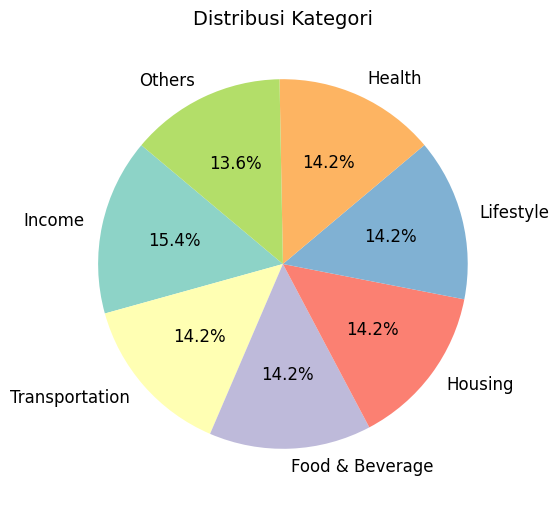

In [17]:
# Bersihkan dan standarkan label kategori
clean_df['kategori'] = df['kategori'].str.strip().str.title()

# Hitung jumlah masing-masing kategori
label_counts = clean_df['kategori'].value_counts()

# Hilangkan kategori dengan jumlah 0 (jika ada)
label_counts = label_counts[label_counts > 0]

# Ambil warna dari colormap Set3
colors = plt.cm.Set3.colors[:len(label_counts)]

# Plot pie chart distribusi kategori
plt.figure(figsize=(6,6))
plt.pie(label_counts.values,
        labels=label_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        textprops={'fontsize':12})
plt.title("Distribusi Kategori", fontsize=14)
plt.show()

📌 **Insight:** Pie chart ini menunjukkan bahwa distribusi kategori cukup seimbang, dengan setiap kategori memiliki proporsi yang hampir sama, berkisar antara 13% hingga 15%. Kategori Pemasukan memiliki proporsi terbesar (15.4%), sedangkan Others memiliki proporsi terkecil (13.6%). Keseimbangan ini mengindikasikan bahwa model yang dilatih dengan data ini kemungkinan tidak akan bias terhadap kategori mayoritas, sehingga dapat memberikan prediksi yang lebih adil untuk semua kelas.

## 🔹 WordCloud per Kategori
WordCloud adalah cara visual yang menarik untuk melihat kata-kata yang paling sering muncul dalam setiap kategori. Hal ini membantu dalam eksplorasi awal untuk memahami konteks atau kebiasaan kata yang muncul berdasarkan kategori transaksi.

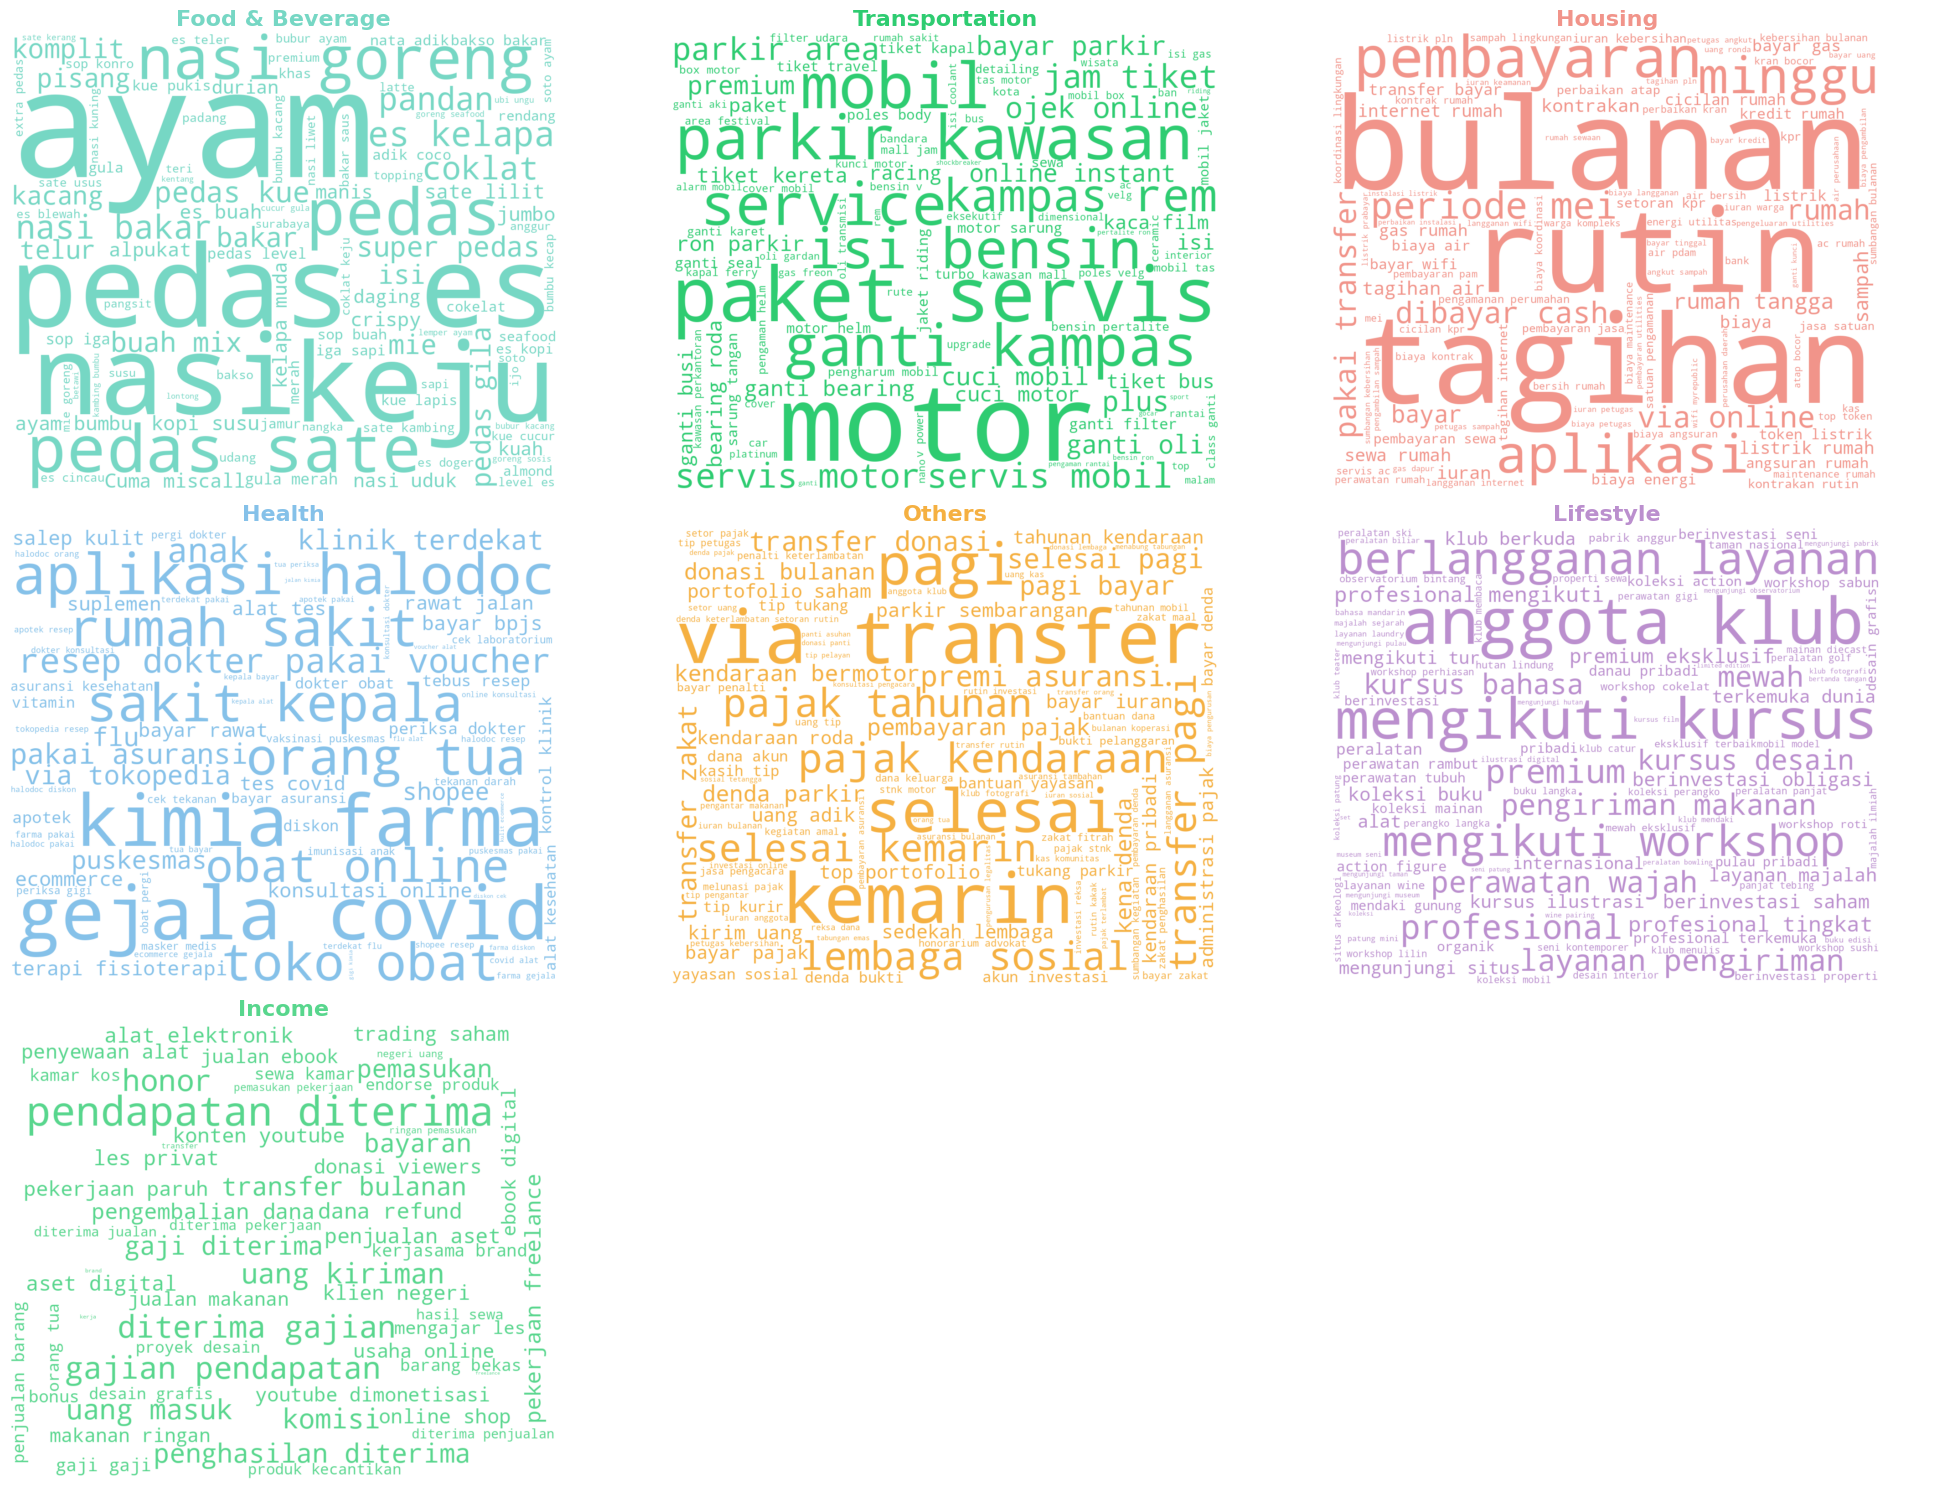

In [18]:
# Ambil semua kategori unik
kategori_unik = df['kategori'].str.strip().str.title().unique()

# Siapkan warna untuk setiap kategori
warna_kategori = {
    'Food & Beverage':  '#76D7C4',  # Hijau toska muda (Turquoise)
    'Transportation':   '#2ECC71',  # Hijau segar cerah (Emerald Green)
    'Lifestyle':        '#BB8FCE',  # Ungu muda (Light Purple / Lavender)
    'Housing':          '#F1948A',  # Merah muda peach (Light Coral / Salmon Pink)
    'Health':           '#85C1E9',  # Biru muda cerah (Light Sky Blue)
    'Others':           '#F5B041',  # Oranye keemasan lembut (Saffron / Gold Orange)
    'Income':           '#58D68D'   # Hijau stabil medium (Medium Aquamarine / Sea Green)
}

# Siapkan grid plot
n = len(kategori_unik)
cols = 3
rows = (n + cols - 1) // cols
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 5 * rows))
axs = axs.flatten()

# Loop untuk buat WordCloud tiap kategori
for i, kategori in enumerate(kategori_unik):

    # Gabungkan teks dari kategori tersebut
    teks = clean_df.loc[clean_df['kategori'].str.strip().str.title() == kategori, 'text_akhir'].dropna().str.cat(sep=' ')

    # Buat word cloud
    wc = WordCloud(
        width=1200,
        height=1000,
        background_color='white',
        color_func=lambda *args, **kwargs: warna_kategori[kategori],
        contour_color='black',
        contour_width=1.5,
        max_words=100,
        random_state=42
    ).generate(teks)

    # Tampilkan
    axs[i].imshow(wc, interpolation='bilinear')
    axs[i].axis('off')
    axs[i].set_title(kategori, fontsize=16, fontweight='bold', color=warna_kategori[kategori])

# Kosongkan grid yang tidak terpakai
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

📌 **Insight:** Visualisasi WordCloud ini membantu mengidentifikasi kata-kata yang paling sering muncul di setiap kategori transaksi. Misalnya, pada kategori Food & Beverage, kata seperti ayam, nasi, dan pedas mendominasi, mencerminkan konteks makanan yang umum. Di sisi lain, kategori Transportation banyak memuat kata seperti motor, servis, dan parkir, menunjukkan frekuensi transaksi terkait kendaraan. Kategori lain seperti Housing, Kesehatan, dan Lifestyle juga menampilkan kata-kata khas yang relevan dengan konteksnya, seperti tagihan, halodoc, dan berlangganan.

# 🧠 Modeling: Memprediksi Kategori Teks dengan Tiga Pendekatan
Pada bagian ini, kita akan membangun dan mengevaluasi beberapa model machine learning untuk memprediksi kategori dari sebuah teks. Tiga pendekatan akan digunakan: klasifikasi sederhana berbasis TF-IDF, CNN, dan LSTM. Kita mulai dari pendekatan paling sederhana.


## 📘 Skema 1: Model Klasifikasi Sederhana (TF-IDF + ML)
Model ini menggunakan teknik TF-IDF (Term Frequency–Inverse Document Frequency) untuk mengubah teks menjadi representasi numerik, kemudian dilatih menggunakan berbagai algoritma machine learning klasik seperti Random Forest, Decision Tree, SVM, Logistic Regression, dan Naive Bayes.



In [19]:
# Pisahkan data menjadi fitur (teks) dan label (kategori)
X = clean_df['text_akhir']
y = clean_df['kategori']

# Ekstraksi fitur menggunakan TF-IDF
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8)
X_tfidf = tfidf.fit_transform(X)

# Konversi hasil TF-IDF menjadi DataFrame agar lebih mudah dibaca
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Menampilkan beberapa baris hasil transformasi
features_df.head()

,air,alat,anak,anggota,aplikasi,apotek,aset,asuransi,ayam,bakar,...,usaha,vaksinasi,via,viewers,vitamin,voucher,wifi,workshop,youtube,zakat
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


💡 **Insight:** TF-IDF berhasil mengubah teks menjadi matriks numerik dengan bobot yang menggambarkan pentingnya kata dalam dokumen. Jumlah fitur dibatasi agar model tetap ringan dan tidak overfitting.

### 🧪 Pelatihan dan Evaluasi Model Klasik

In [20]:
# Split data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=4
)

# Inisialisasi model-model klasik
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(kernel='linear', probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB()
}

# Melatih dan mengevaluasi semua model
for nama, model in models.items():
    print(f"\n===== {nama} =====")

    model.fit(X_train, y_train)  # Melatih model
    models[nama] = model         # Simpan model yang sudah dilatih

    y_pred = model.predict(X_test)  # Prediksi data uji
    acc = accuracy_score(y_test, y_pred)  # Hitung akurasi
    print(f"Akurasi: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


===== Random Forest =====
Akurasi: 0.9418
Classification Report:
                 precision    recall  f1-score   support

Food & Beverage       0.76      0.99      0.86       206
         Health       0.99      1.00      1.00       177
        Housing       0.98      0.98      0.98       190
         Income       1.00      1.00      1.00       228
      Lifestyle       0.99      0.86      0.92       212
         Others       0.98      0.97      0.97       200
 Transportation       0.94      0.80      0.86       197

       accuracy                           0.94      1410
      macro avg       0.95      0.94      0.94      1410
   weighted avg       0.95      0.94      0.94      1410


===== Decision Tree =====
Akurasi: 0.9418
Classification Report:
                 precision    recall  f1-score   support

Food & Beverage       0.76      0.99      0.86       206
         Health       0.99      1.00      1.00       177
        Housing       0.99      0.98      0.98       190
         

📊 **Insight:** Model klasik seperti Logistic Regression, Random Forest, Decision Tree, dan SVM menunjukkan performa yang sangat baik dengan akurasi di atas 94%, di mana Logistic Regression mencatat akurasi tertinggi sebesar 94.54%. Keempat model ini konsisten dalam mengenali kategori yang akan diprediksi dengan skor f1 mendekati sempurna. Sementara itu, Naive Bayes tertinggal dengan akurasi 89.29% dan cenderung kesulitan membedakan kategori tertentu seperti Pemasukan.

### 🔮 Inferensi Teks Baru

In [21]:
# Input teks baru dari pengguna
teks_input = input("Masukkan teks: ")

# Ekstraksi amount dari teks asli (belum diproses)
amounts = extract_amount(teks_input)

# Lakukan preprocessing seperti saat training
teks_clean = cleaningText(teks_input)
teks_casefold = casefoldingText(teks_clean)
teks_slang = fix_slangwords(teks_casefold)
teks_token = tokenizingText(teks_slang)
teks_stop = filteringText(teks_token)
teks_final = toSentence(teks_stop)

# Transformasi ke bentuk TF-IDF
input_tfidf = tfidf.transform([teks_final])

# Lakukan prediksi dengan model yang dipilih (misal: Random Forest)
prediksi = models["Random Forest"].predict(input_tfidf)

# Tampilkan hasil prediksi dan nominal
print(f"\nTeks setelah preprocessing: {teks_final}")
print(f"Prediksi kategori: {prediksi[0]}")

if amounts:
    print(f"Jumlah nominal yang terdeteksi: {amounts}")
else:
    print("Tidak ada nominal yang terdeteksi.")

Masukkan teks: Beli obat 40.000

Teks setelah preprocessing: obat
Prediksi kategori: Health
Jumlah nominal yang terdeteksi: 40000


## 📘 Skema 2: Model CNN (Convolutional Neural Network)
Model ini memanfaatkan jaringan saraf konvolusional (CNN) untuk melakukan klasifikasi teks. CNN efektif dalam mengenali pola lokal dalam urutan kata (n-gram), membuatnya cocok untuk tugas klasifikasi teks pendek seperti deskripsi.

### 📌 Tokenisasi, Padding, dan Encoding Label

In [22]:
# Input dan Label
X = clean_df['text_akhir'].astype(str)
y = clean_df['kategori']

# Encode label ke numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Tokenisasi dan padding
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, padding='post', maxlen=100)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_pad, y_categorical, test_size=0.2, stratify=y_encoded, random_state=42)

### 🏗️ Arsitektur Model CNN

In [23]:
# Bangun arsitektur CNN
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(y_categorical.shape[1], activation='softmax')
])

# Kompilasi model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Tampilkan arsitektur model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### 🏋️‍♂️ Pelatihan Model

In [24]:
# Latih model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.4523 - loss: 1.6213 - val_accuracy: 0.9743 - val_loss: 0.0920
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9865 - loss: 0.0681 - val_accuracy: 0.9885 - val_loss: 0.0371
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9976 - loss: 0.0162 - val_accuracy: 0.9894 - val_loss: 0.0325
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9986 - loss: 0.0077 - val_accuracy: 0.9929 - val_loss: 0.0247
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9993 - loss: 0.0040 - val_accuracy: 0.9920 - val_loss: 0.0271
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9992 - loss: 0.0028 - val_accuracy: 0.9894 - val_loss: 0.0295
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9999 - loss: 0.0016 - val_accuracy: 0.9894 - val_loss: 0.0306
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 9.7092e-04 - val_accurac

📈 **Insight:** Selama 10 epoch pelatihan dengan 20% data sebagai validation set, akurasi training awal rendah (45%) namun validasi langsung tinggi (97%), kemungkinan akibat distribusi data atau inisialisasi model. Akurasi training meningkat pesat hingga 100%, sementara akurasi validasi tetap stabil tinggi di kisaran 98–99% dengan penurunan loss yang konsisten. Meskipun terjadi sedikit kenaikan loss validasi di akhir, tidak terlihat tanda overfitting serius. Hasil ini menunjukkan model belajar dengan sangat baik dan memiliki kemampuan generalisasi yang kuat terhadap data baru.

### 🧪 Evaluasi Model


In [25]:
# Evaluasi akurasi model
loss, acc = model.evaluate(X_test, y_test)
print(f"Akurasi CNN: {acc:.4f}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9868 - loss: 0.0440
Akurasi CNN: 0.9901


📈 **Insight:** 📊 Insight: Model CNN menunjukkan performa sangat baik pada data pengujian, dengan akurasi mencapai 99.01% dan loss yang sangat rendah (0.0440). Hasil ini konsisten dengan akurasi validasi selama pelatihan, mengindikasikan bahwa model memiliki kemampuan generalisasi yang tinggi dan tidak mengalami overfitting. Evaluasi ini memperkuat bahwa model siap digunakan untuk prediksi pada data nyata dengan tingkat kepercayaan yang sangat tinggi.

### 🔍 Prediksi Probabilitas dan Penanganan Ketidakpastian


In [26]:
# Prediksi probabilitas
pred_proba = model.predict(X_test)

# Ambil probabilitas tertinggi dan indeks kelas
conf = np.max(pred_proba, axis=1)
pred_label_idx = np.argmax(pred_proba, axis=1)

# Decode ke label kategori
pred_labels = label_encoder.inverse_transform(pred_label_idx)

# Terapkan threshold keyakinan
final_labels = []
for i in range(len(conf)):
    if conf[i] < 0.7:
        final_labels.append('Lainnya')
    else:
        final_labels.append(pred_labels[i])

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


⚠️ **Insight:** Jika model kurang yakin (confidence < 0.7), maka diklasifikasikan sebagai 'Lainnya'. Ini membantu menghindari prediksi yang keliru pada teks ambigu atau tidak familiar.



### 🔮 Inferensi Teks Baru


In [27]:
# Fungsi prediksi teks baru
def prediksi_cnn(teks):
    # Ekstraksi nominal dari teks asli
    amounts = extract_amount(teks)

    # Preprocessing
    teks_clean = cleaningText(teks)
    teks_casefold = casefoldingText(teks_clean)
    teks_slang = fix_slangwords(teks_casefold)
    teks_token = tokenizingText(teks_slang)
    teks_stop = filteringText(teks_token)
    teks_final = toSentence(teks_stop)

    # Tokenisasi & Padding
    seq = tokenizer.texts_to_sequences([teks_final])
    pad = pad_sequences(seq, maxlen=100, padding='post')

    # Prediksi
    pred = model.predict(pad)
    conf = np.max(pred)
    idx = np.argmax(pred)

    # Tampilkan informasi
    print(f"Teks setelah preprocessing: {teks_final}")
    print(f"Confidence: {conf:.4f}")
    if amounts:
        print(f"Jumlah nominal yang terdeteksi: {amounts}")
    else:
        print("Tidak ada nominal yang terdeteksi.")

    if conf < 0.5:
        return "Lainnya"
    else:
        return label_encoder.inverse_transform([idx])[0]

### ▶️ Contoh Penggunaan


In [28]:
teks_input = input("Masukkan teks: ")
kategori = prediksi_cnn(teks_input)
print(f"Kategori yang diprediksi: {kategori}")

Masukkan teks: Beli motor listrik 7.000.000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
Teks setelah preprocessing: motor listrik
Confidence: 0.6110
Jumlah nominal yang terdeteksi: 7000000
Kategori yang diprediksi: Transportation


## 📘 Skema 3: Klasifikasi Teks Menggunakan LSTM dan Tokenizer
Model ini menggunakan pendekatan Deep Learning berbasis LSTM untuk melakukan klasifikasi teks ke dalam kategori tertentu. Skema ini cocok untuk menangani urutan teks yang kompleks karena LSTM mampu mengingat konteks dalam urutan kata.




### 🔹 Menyiapkan Fitur Teks dan Label

In [29]:
# Ambil kolom teks dan label dari dataset
texts = clean_df['text_akhir'].astype(str)
labels = clean_df['kategori']

In [30]:
# Encode label dari string menjadi angka
le = LabelEncoder()
y_encoded = le.fit_transform(labels)

In [31]:
# Tampilkan hasil encoding dan urutan label
print("Encoded:", y_encoded)
print("Label urutan:", le.classes_)

Encoded: [0 0 0 ... 3 3 3]
Label urutan: ['Food & Beverage' 'Health' 'Housing' 'Income' 'Lifestyle' 'Others'
 'Transportation']


### 🔹 Tokenisasi dan Padding Teks


In [32]:
# Inisialisasi tokenizer dengan jumlah kata maksimum dan OOV token
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

# Ubah teks menjadi urutan angka dan lakukan padding
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=max_len)

In [33]:
# Tampilkan distribusi label
print(pd.Series(y_encoded).value_counts())

3    1087
6    1003
0    1000
2    1000
4    1000
1     998
5     958
Name: count, dtype: int64


In [34]:
# Hitung jumlah kelas unik
num_classes = len(np.unique(y_encoded))

### 🔹 Membagi Data Menjadi Train dan Test

In [35]:
# Split data menjadi train dan test secara stratified
X_train, X_test, y_train_int, y_test_int = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [36]:
# One-hot encoding untuk label train dan test
y_train = to_categorical(y_train_int, num_classes=num_classes)
y_test = to_categorical(y_test_int, num_classes=num_classes)

### 🧱 Arsitektur dan Kompilasi Model LSTM


In [37]:
# Bangun arsitektur model LSTM
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(128),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Kompilasi model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### 🏋️ Training Model dengan EarlyStopping


In [38]:
# Inisialisasi callback early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Latih model dengan validation split
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.2276 - loss: 1.9235 - val_accuracy: 0.6534 - val_loss: 1.5982
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5923 - loss: 1.3112 - val_accuracy: 0.9663 - val_loss: 0.2371
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9225 - loss: 0.2897 - val_accuracy: 0.9876 - val_loss: 0.0621
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9775 - loss: 0.0927 - val_accuracy: 0.9858 - val_loss: 0.0489
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9941 - loss: 0.0429 - val_accuracy: 0.9849 - val_loss: 0.0468
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9927 - loss: 0.0325 - val_accuracy: 0.9938 - val_loss: 0.0311
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9950 - loss: 0.0230 - val_accuracy: 0.9911 - val_loss: 0.0361
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9964 - loss: 0.0171 - val_accuracy: 0.9929 - v

📌 **Insight:** Model dilatih selama 10 epoch dan menunjukkan peningkatan signifikan dari akurasi awal yang rendah (22.76%) hingga mencapai lebih dari 99% pada data training. Akurasi validasi juga meningkat tajam dari 65% di awal menjadi stabil tinggi di atas 99% mulai epoch ke-6, dengan nilai loss yang terus menurun. Meskipun ada sedikit fluktuasi pada loss validasi di epoch akhir, perbedaan antara training dan validation sangat kecil, menandakan model belajar dengan efektif tanpa overfitting. Secara keseluruhan, performa model sangat baik dan siap digunakan untuk prediksi pada data baru.










### 📈 Evaluasi Model

In [39]:
# Evaluasi akurasi pada data train
train_loss, train_acc = model.evaluate(X_train, y_train)

# Evaluasi akurasi pada data test
test_loss, test_acc = model.evaluate(X_test, y_test)

# Cetak hasil evaluasi
print("\nTrain Accuracy:", round(train_acc * 100, 2), "%")
print("Test Accuracy:", round(test_acc * 100, 2), "%")

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9999 - loss: 0.0025
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9840 - loss: 0.0529

Train Accuracy: 99.86 %
Test Accuracy: 98.87 %


📊 **Insight:** Model menunjukkan performa yang sangat baik dengan akurasi training mencapai 99.86% dan akurasi testing 98.87%, serta loss yang sangat rendah di kedua dataset. Perbedaan akurasi yang kecil antara training dan testing mengindikasikan bahwa model belajar dengan optimal tanpa overfitting, dan memiliki kemampuan generalisasi yang sangat kuat terhadap data baru.










### 🔍 Prediksi Label dengan Confidence Threshold


In [40]:
# Prediksi probabilitas dari model untuk data test
pred_proba = model.predict(X_test)

# Ambil confidence tertinggi dan indeks label prediksi
conf = np.max(pred_proba, axis=1)
pred_idx = np.argmax(pred_proba, axis=1)

# Decode indeks prediksi menjadi nama label
pred_labels = le.inverse_transform(pred_idx)

# Tentukan final label dengan ambang batas confidence
final_labels = []
for i in range(len(conf)):
    if conf[i] < 0.5:
        final_labels.append('Lainnya')
    else:
        final_labels.append(pred_labels[i])

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


### 📋 Classification Report


In [41]:
# Hitung prediksi dan nilai sebenarnya
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Cetak classification report
from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(y_true, y_pred))

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       200
           1       1.00      1.00      1.00       200
           2       1.00      1.00      1.00       200
           3       1.00      1.00      1.00       217
           4       0.97      0.98      0.97       200
           5       0.99      1.00      1.00       192
           6       0.99      0.95      0.97       201

    accuracy                           0.99      1410
   macro avg       0.99      0.99      0.99      1410
weighted avg       0.99      0.99      0.99      1410



📌 **Insight:** Model mencapai akurasi keseluruhan 99% dengan nilai precision, recall, dan F1-score yang sangat tinggi pada hampir semua kelas (rata-rata ≥ 0.97). Performa terbaik ditunjukkan pada kelas 1, 2, dan 3 yang memiliki skor sempurna (1.00), sementara kelas 0, 4, dan 6 sedikit lebih rendah namun tetap sangat baik. Distribusi support yang relatif seimbang menunjukkan bahwa model mampu mengklasifikasikan seluruh kelas secara konsisten tanpa bias yang mencolok.

### 🔍 Uji Fungsi Prediksi


In [42]:
# Fungsi prediksi teks dengan threshold confidence
def predict_category(text, threshold=0.8):
    sequence = tokenizer.texts_to_sequences([text])
    padded_seq = pad_sequences(sequence, maxlen=max_len)
    pred_proba = model.predict(padded_seq)
    confidence = np.max(pred_proba)
    pred_class_idx = np.argmax(pred_proba, axis=1)[0]

    print(f"Confidence: {confidence:.4f}")

    if confidence < threshold:
        return 'Lainnya'
    else:
        return le.inverse_transform([pred_class_idx])[0]

In [45]:
# Input teks dari user
input_text = input("Masukkan teks: ")

# Prediksi kategori
kategori_prediksi = predict_category(input_text)
# Ekstraksi amount
amounts = extract_amount(input_text)

# Tampilkan hasil
print(f"Kategori yang diprediksi: {kategori_prediksi}")
if amounts:
    print(f"Jumlah nominal yang terdeteksi: {amounts}")
else:
    print("Tidak ada nominal yang terdeteksi.")

Masukkan teks: beli pipa air 30.000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Confidence: 0.8852
Kategori yang diprediksi: Housing
Jumlah nominal yang terdeteksi: 30000


### 💾 Menyimpan Model LSTM dan Tokenizer


In [44]:
# Menyimpan model LSTM
model.save("model/nlp_model.h5")

# Menyimpan tokenizer
import pickle
with open("model/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)